Цели:
1)Проведите первичную обработку данных. Так как данных много, стоит написать функции, которые можно применять к столбцам определённого типа.
2)Посмотрите на распределение признака для числовых переменных, устраните выбросы.
3)Оцените количество уникальных значений для номинативных переменных.
4)По необходимости преобразуйте данные
5)Проведите корреляционный анализ количественных переменных
6)Отберите не коррелирующие переменные.
7)Проанализируйте номинативные переменные и устраните те, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
8)Не забудьте сформулировать выводы относительно качества данных и тех переменных, которые вы будете использовать в дальнейшем построении модели.

Описание датасета (переменные, которые содержит датасет):

school — аббревиатура школы, в которой учится ученик
sex — пол ученика ('F' - женский, 'M' - мужской)
age — возраст ученика (от 15 до 22)
address — тип адреса ученика ('U' - городской, 'R' - за городом)
famsize — размер семьи('LE3' <= 3, 'GT3' >3)
Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
failures — количество внеучебных неудач (n, если 1<=n<3, иначе 4)
schoolsup — дополнительная образовательная поддержка (yes или no)
famsup — семейная образовательная поддержка (yes или no)
paid — дополнительные платные занятия по математике (yes или no)
activities — дополнительные внеучебные занятия (yes или no)
nursery — посещал детский сад (yes или no)
higher — хочет получить высшее образование (yes или no)
internet — наличие интернета дома (yes или no)
romantic — в романтических отношениях (yes или no)
famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
absences — количество пропущенных занятий
score — баллы по госэкзамену по математике


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [157]:
pd.set_option('display.max_rows', 100) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

In [158]:
#Поиск выбросов
def find_overvalues(frame):
    q1=pd.DataFrame.quantile(frame, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')
    q3=pd.DataFrame.quantile(frame, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')
    mid=q3-q1
    result={}
    result['lowLimit']= q1-mid*1.5
    result['highLimit']= q3+mid*1.5
    return result

#Выборка значений без выбросов
def clear_frame(frame):
    overlaps=find_overvalues(frame)
    return frame[((frame>=overlaps['lowLimit'])&(frame<=overlaps['highLimit']))]

#Поиск межквантильного расстояния
def calc_iqr(frame):
    q3=pd.DataFrame.quantile(frame, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')
    q1=pd.DataFrame.quantile(frame, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')
    return q3-q1

#функция отсечки выбросов
def check_over_limits(frame, fieldName):
    if (frame.dtypes[fieldName] == np.number):
        overlaps=find_overvalues(frame)
        return frame.loc[frame[fieldName].between(overlaps['lowLimit'][fieldName], overlaps['highLimit'][fieldName])]
    else:
        return frame
    
#функция поиска статистически значимых параметров по Стъюденту    
def get_stat_dif(frame, column, var='score'):
    cols = frame.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(frame.loc[frame.loc[:, column] == comb[0], var].astype(float), 
                        frame.loc[frame.loc[:, column] == comb[1], var].astype(float)).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
#функция отрисовки боксплота
def get_boxplot(frame, column, axess):
    fig, ax = plt.subplots(figsize = (14, 4))
    frame[axess]=frame[axess].apply(float)
    sns.boxplot(x=column, y=axess, 
                data=frame.loc[frame.loc[:, column].isin(frame.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

#функция поиска пустых значений
def find_empty_fields(frame, field):
    return frame.loc[(frame[field].notnull()) & frame[field].ne('True')][field]

#функция вывода уникальных значений и пропусков в датасете
def show_unique_fields(frame, field):
    display(pd.DataFrame(frame[field].value_counts()).sort_values(by=field))
    result=find_empty_fields(frame, field)  
    display(result[100:150])
    print("Значений, встретившихся в столбце более 10 раз:", (result.value_counts()>10).sum())
    print('Количество пропусков в наборе данных в',field,':',frame.shape[0]-result.value_counts().sum())
    return result

#Агрегация пустых ячеек
def check_empty_cell_string(x):
    if pd.isnull(x):
         return None
#    if np.isnan(x):
#        return None
    if x == 'nan':
        return None
    if x == 'NaN':
        return None
    return x    

#Функция для построения графической и справочноц информации способствующей анализу данных
def get_info(frame, field):
    frame.loc[:, [field]].info()
    if (frame.dtypes[field] == np.number):        
        calc_quantiles(frame, field)
        print('Минимальное значение:', frame[field].min())
        print('Максимальное значение:', frame[field].max())
        print(frame[field].nunique())
#        plt.cla()
        plt.plot(check_over_limits(frame, field)[field])       
        plt.show()
        plot_hist(frame,field, frame[field].min(), frame[field].max())
#        plt.cla()
        plt.show()
#        plt.cla()
        get_boxplot(frame, field, 'score')
    else:
        get_boxplot(frame, field, 'score')


#Функкция для агрегации диапазона
def check_overlap_cell(x, low, hi):
    if (x>=low) and (x<=hi):
        return x
    else: None

#Очистка от выбросов        
def clear_overlaps_fields(frame, field):
    frame[not check_over_limits(frame, field)]=None
    return frame[field]

#функция поиска квантилей
def calc_quantiles(frame, field):
    median = frame[field].median()
    IQR = frame[field].quantile(0.75) - frame[field].quantile(0.25)
    perc25 = frame[field].quantile(0.25)
    perc75 = frame[field].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

#Функция оценки значений внутри ОДЗ и выбрососв
def plot_hist(frame, field, minODZ, maxODZ):
    median = frame[field].astype(float).median()
    IQR = frame[field].astype(float).quantile(0.75) - frame[field].astype(float).quantile(0.25)
    perc25 = frame[field].astype(float).quantile(0.25)
    perc75 = frame[field].astype(float).quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    frame[field].loc[frame[field].astype(float).between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (minODZ, maxODZ), 
                                                                                             label = 'IRQ ' + field)
    frame[field].loc[(frame[field].astype(float) <= maxODZ)&(frame[field].astype(float) >= minODZ)].hist(alpha = 0.5, bins = 16, range = (0, 10),
                                                        label = 'Здравый смысл ' + field)
    plt.legend();
    
    

def plot_hist_se(frame, field, minODZ, maxODZ):
    plt.clf()
    plt.cla()
    plt.close()
    median = frame[field].astype(float).median()
    IQR = frame[field].astype(float).quantile(0.75) - frame[field].astype(float).quantile(0.25)
    perc25 = frame[field].astype(float).quantile(0.25)
    perc75 = frame[field].astype(float).quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    frame[field].loc[frame[field].astype(float).between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), 
                                                                                             label = 'IQR')
    frame[field].loc[(frame[field].astype(float) <= maxODZ)&(frame[field].astype(float) >= minODZ)].hist(alpha = 0.5, bins = 16, range = (0, 10),
                                                        label = 'Здравый смысл')
    plt.legend();    
    
#функция корректировки имен в заголовках таблицы
def correct_names(x):
    return x.lower().replace(', ','_')
#функция корректировки значений внутри диапазона для колонки
def correct_values(frame, field, minV, maxV):
    frame[field]=frame[field].loc[frame[field].astype(float).between(minV, maxV)]
#функция корректировки NaN значений    
def correct_NaN2Zero(x):
    if np.isnan(x):
        return 0
    return x
    

In [159]:
data = pd.read_csv('stud_math.xls')
new_coll=[]
dict_types={}
for coll in data.columns:
    new_coll.append(correct_names(coll))
    if not data.dtypes[coll] in dict_types.keys():
        dict_types[data.dtypes[coll]]=[]
        dict_types[data.dtypes[coll]].append(correct_names(coll))
    else:
        dict_types[data.dtypes[coll]].append(correct_names(coll))
data.columns=new_coll
dict_types

{dtype('O'): ['school',
  'sex',
  'address',
  'famsize',
  'pstatus',
  'mjob',
  'fjob',
  'reason',
  'guardian',
  'schoolsup',
  'famsup',
  'paid',
  'activities',
  'nursery',
  'higher',
  'internet',
  'romantic'],
 dtype('int64'): ['age'],
 dtype('float64'): ['medu',
  'fedu',
  'traveltime',
  'studytime',
  'failures',
  'studytime_granular',
  'famrel',
  'freetime',
  'goout',
  'health',
  'absences',
  'score']}

In [160]:
data[100:150]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
100,GP,M,16,U,GT3,T,4.0,4.0,services,services,other,mother,1.0,1.0,0.0,yes,yes,yes,yes,yes,-3.0,yes,yes,no,4.0,5.0,5.0,4.0,14.0,25.0
101,GP,M,16,U,GT3,T,4.0,4.0,services,teacher,other,father,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,4.0,NaN,85.0
102,GP,M,15,U,GT3,T,4.0,4.0,services,other,course,mother,1.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,no,NaN,3.0,3.0,5.0,4.0,70.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
105,GP,F,15,U,GT3,A,3.0,3.0,other,health,reputation,father,1.0,4.0,0.0,yes,no,no,no,yes,-12.0,yes,no,no,4.0,3.0,3.0,4.0,10.0,55.0
106,GP,F,15,U,GT3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,no,5.0,1.0,2.0,3.0,8.0,40.0
107,GP,M,16,U,GT3,T,3.0,3.0,services,NaN,home,father,1.0,3.0,NaN,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,3.0,3.0,5.0,2.0,90.0
108,GP,M,15,R,GT3,NaN,4.0,4.0,other,other,home,father,4.0,4.0,NaN,no,yes,yes,yes,yes,-12.0,yes,yes,yes,1.0,3.0,5.0,1.0,6.0,65.0
109,GP,F,16,U,LE3,T,4.0,4.0,health,health,other,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,5.0,4.0,5.0,4.0,4.0,80.0


In [161]:
for col in data.columns:
    data[col] = data[col].astype(str).apply(check_empty_cell_string) 
    data[col] = show_unique_fields(data, col)  

data

,school
MS,46
GP,349


100    GP
101    GP
102    GP
103    GP
104    GP
105    GP
106    GP
107    GP
108    GP
109    GP
110    GP
111    GP
112    GP
113    GP
114    GP
115    GP
116    GP
117    GP
118    GP
119    GP
120    GP
121    GP
122    GP
123    GP
124    GP
125    GP
126    GP
127    GP
128    GP
129    GP
130    GP
131    GP
132    GP
133    GP
134    GP
135    GP
136    GP
137    GP
138    GP
139    GP
140    GP
141    GP
142    GP
143    GP
144    GP
145    GP
146    GP
147    GP
148    GP
149    GP
Name: school, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в school : 0


,sex
M,187
F,208


100    M
101    M
102    M
103    F
104    M
105    F
106    F
107    M
108    M
109    F
110    M
111    F
112    F
113    M
114    M
115    M
116    M
117    M
118    M
119    M
120    F
121    M
122    F
123    M
124    F
125    M
126    F
127    F
128    M
129    M
130    F
131    F
132    F
133    F
134    M
135    F
136    M
137    F
138    M
139    F
140    M
141    M
142    F
143    F
144    M
145    F
146    F
147    F
148    M
149    M
Name: sex, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в sex : 0


,age
21,1
22,1
20,3
19,24
15,82
18,82
17,98
16,104


100    16
101    16
102    15
103    15
104    15
105    15
106    15
107    16
108    15
109    16
110    15
111    16
112    16
113    15
114    15
115    16
116    15
117    16
118    17
119    15
120    15
121    15
122    16
123    16
124    16
125    15
126    15
127    19
128    18
129    16
130    15
131    15
132    17
133    16
134    15
135    15
136    17
137    16
138    16
139    15
140    15
141    16
142    15
143    16
144    17
145    15
146    15
147    15
148    16
149    15
Name: age, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в age : 0


,address
R,83
U,295


105    U
106    U
107    U
108    R
109    U
110    U
111    R
112    U
113    U
114    R
115    U
116    U
117    U
118    R
119    U
120    U
121    U
122    U
123    U
124    U
125    U
126    U
127    U
128    R
129    R
130    R
131    U
132    U
133    U
134    R
135    U
136    R
137    U
138    U
139    U
140    U
141    U
142    U
143    U
144    U
145    U
146    U
147    U
148    U
149    U
150    U
151    U
152    R
153    U
154    U
Name: address, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в address : 17


,famsize
LE3,107
GT3,261


107    GT3
108    GT3
109    LE3
110    LE3
111    GT3
112    GT3
113    LE3
115    GT3
116    GT3
117    GT3
118    GT3
119    GT3
120    GT3
121    GT3
122    LE3
123    GT3
124    GT3
125    GT3
126    LE3
127    GT3
130    GT3
131    GT3
132    LE3
133    GT3
134    GT3
135    GT3
136    GT3
137    GT3
138    LE3
139    GT3
140    GT3
141    LE3
142    GT3
143    LE3
144    GT3
145    GT3
146    GT3
147    GT3
148    GT3
149    LE3
150    LE3
151    LE3
152    GT3
153    GT3
154    GT3
155    GT3
156    LE3
157    GT3
158    GT3
159    GT3
Name: famsize, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в famsize : 27


,pstatus
A,36
T,314


113    T
114    T
115    T
116    T
117    T
118    T
119    T
120    T
121    T
122    T
123    T
124    T
125    T
126    A
127    T
128    T
129    T
130    T
132    T
133    A
134    T
135    T
136    T
137    A
138    T
140    T
141    T
142    T
143    T
144    T
145    T
146    T
148    T
150    T
151    T
152    T
154    T
155    T
156    T
157    T
159    T
160    T
161    T
162    T
163    T
164    T
165    T
166    T
167    T
168    T
Name: pstatus, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в pstatus : 45


,medu
0.0,3
1.0,59
3.0,97
2.0,102
4.0,131


101    4.0
102    4.0
103    3.0
104    3.0
105    3.0
106    2.0
107    3.0
108    4.0
109    4.0
110    4.0
111    3.0
112    2.0
113    4.0
114    2.0
115    4.0
116    4.0
117    3.0
118    1.0
119    3.0
120    1.0
121    2.0
122    2.0
123    4.0
124    2.0
125    3.0
126    3.0
127    0.0
128    2.0
129    4.0
130    3.0
131    1.0
132    2.0
133    3.0
134    3.0
135    4.0
136    3.0
137    3.0
138    1.0
139    4.0
140    4.0
141    2.0
142    4.0
143    1.0
144    2.0
145    1.0
146    3.0
147    1.0
148    4.0
149    2.0
150    1.0
Name: medu, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в medu : 3


,fedu
40.0,1
0.0,2
1.0,78
4.0,88
3.0,96
2.0,106


106    2.0
107    3.0
108    4.0
109    4.0
110    4.0
111    3.0
112    2.0
113    2.0
114    1.0
115    4.0
116    4.0
117    3.0
118    3.0
119    4.0
120    2.0
121    2.0
122    4.0
123    4.0
124    2.0
125    4.0
126    4.0
127    1.0
128    2.0
129    4.0
130    4.0
131    1.0
132    2.0
133    4.0
134    4.0
135    4.0
136    4.0
138    1.0
139    4.0
140    3.0
141    2.0
143    1.0
144    1.0
145    1.0
146    2.0
147    2.0
148    4.0
149    1.0
150    1.0
151    1.0
152    3.0
153    2.0
154    4.0
155    3.0
156    2.0
157    1.0
Name: fedu, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в fedu : 24


,mjob
health,32
teacher,55
at_home,58
services,98
other,133


105       other
106       other
107    services
108       other
109      health
110     teacher
111    services
112     at_home
113     teacher
114      health
115     teacher
116       other
117       other
118       other
119       other
120     at_home
121    services
122       other
123      health
124       other
125    services
126       other
127     at_home
129     teacher
130    services
131     at_home
132       other
133    services
134     at_home
135    services
136     at_home
137       other
138    services
139     teacher
140     teacher
141    services
142     teacher
143     at_home
144       other
146      health
147     at_home
148     teacher
149    services
150       other
151     at_home
152    services
153    services
154       other
155     at_home
157     at_home
Name: mjob, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в mjob : 19


,fjob
health,15
at_home,16
teacher,29
services,102
other,197


111       other
112       other
113       other
114    services
115     teacher
116     teacher
117    services
119       other
121    services
122      health
123       other
124       other
125    services
126       other
127       other
128       other
129     teacher
130     teacher
131       other
132       other
133       other
134     teacher
136       other
137       other
138       other
139     teacher
140    services
141    services
142    services
143     at_home
144       other
145    services
146    services
147       other
148     teacher
149       other
150       other
153     at_home
154     teacher
155    services
156       other
157       other
158       other
159    services
162       other
163    services
164    services
165    services
166       other
167    services
Name: fjob, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в fjob : 36


,reason
other,34
reputation,103
home,104
course,137


104        course
105    reputation
106        course
107          home
108          home
109         other
110        course
111    reputation
113        course
114    reputation
115        course
116    reputation
117          home
118        course
119    reputation
120        course
121          home
122        course
123        course
124          home
125          home
126          home
127        course
128    reputation
129        course
130        course
131        course
132        course
133        course
134        course
135        course
136        course
139        course
141    reputation
142        course
143        course
144          home
145        course
146          home
147        course
148        course
149        course
150        course
151        course
152    reputation
153          home
154        course
155        course
156    reputation
157        course
Name: reason, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в reason : 17


,guardian
other,28
father,86
mother,250


108    father
109    mother
110    mother
111    father
112    mother
113    mother
114    mother
115    father
116    father
117    father
118    father
119    father
120    mother
121    father
122    father
123    mother
124    mother
125    father
126    mother
127     other
128    mother
129    mother
130    father
131    mother
132    father
133    father
134    mother
135    mother
136    mother
137     other
139    mother
140    father
141    father
142    mother
143    mother
145    father
146    father
147    mother
148    mother
149    mother
150    mother
151    mother
152     other
153    mother
154    mother
155    mother
156    mother
157    mother
158    mother
159    father
Name: guardian, dtype: object

Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в guardian : 31


,traveltime
4.0,7
3.0,22
2.0,96
1.0,242


108    4.0
109    1.0
110    1.0
111    1.0
113    1.0
114    1.0
115    1.0
116    2.0
117    2.0
118    3.0
119    1.0
120    1.0
121    1.0
122    2.0
123    1.0
124    1.0
125    1.0
126    1.0
127    1.0
128    1.0
129    1.0
130    2.0
131    3.0
133    1.0
135    1.0
136    3.0
138    1.0
139    2.0
140    2.0
141    2.0
143    1.0
144    1.0
145    1.0
146    1.0
148    1.0
149    4.0
150    1.0
151    1.0
152    2.0
153    1.0
154    1.0
155    1.0
156    1.0
158    3.0
159    1.0
161    2.0
162    2.0
163    1.0
164    4.0
165    2.0
Name: traveltime, dtype: object

Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в traveltime : 28


,studytime
4.0,27
3.0,64
1.0,103
2.0,194


102    1.0
103    2.0
104    2.0
105    4.0
106    4.0
107    3.0
108    4.0
109    3.0
110    1.0
111    3.0
113    1.0
114    2.0
115    2.0
116    2.0
117    1.0
118    2.0
119    1.0
120    2.0
121    4.0
122    2.0
123    1.0
124    2.0
125    1.0
126    2.0
127    2.0
128    1.0
130    3.0
131    1.0
132    1.0
133    1.0
134    2.0
135    3.0
136    2.0
137    1.0
138    2.0
139    1.0
140    4.0
141    1.0
142    3.0
143    1.0
144    1.0
145    2.0
146    2.0
147    2.0
148    1.0
149    1.0
150    1.0
151    1.0
152    3.0
153    1.0
Name: studytime, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в studytime : 7


,failures
3.0,15
2.0,16
1.0,49
0.0,293


105    0.0
106    0.0
109    0.0
110    0.0
111    1.0
112    1.0
113    0.0
116    0.0
117    0.0
118    1.0
119    0.0
120    0.0
121    0.0
122    0.0
123    0.0
124    0.0
126    0.0
127    3.0
128    2.0
129    0.0
130    2.0
131    0.0
132    0.0
133    0.0
134    0.0
135    0.0
136    0.0
137    2.0
138    1.0
139    0.0
140    0.0
141    2.0
142    0.0
143    0.0
144    3.0
145    0.0
146    3.0
147    0.0
148    0.0
149    3.0
150    3.0
151    1.0
152    2.0
154    0.0
155    0.0
156    0.0
157    3.0
159    1.0
160    2.0
161    2.0
Name: failures, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в failures : 22


,schoolsup
yes,51
no,335


103    yes
104     no
105    yes
106    yes
107     no
108     no
109     no
110     no
111    yes
112    yes
113     no
114     no
115     no
116     no
117     no
118     no
119     no
120     no
121     no
122     no
123     no
124     no
125    yes
126    yes
127     no
128     no
129     no
130     no
131     no
132     no
133     no
134     no
135     no
136     no
137     no
138     no
139     no
140    yes
141     no
142     no
143     no
144     no
145     no
146     no
147     no
148     no
149     no
150     no
152     no
153     no
Name: schoolsup, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в schoolsup : 9


,famsup
no,137
yes,219


112     no
113     no
114     no
115    yes
116    yes
117     no
118    yes
119     no
120     no
121    yes
122    yes
123    yes
124     no
125     no
126     no
128    yes
129     no
130    yes
131    yes
132    yes
133     no
134    yes
135    yes
136     no
137    yes
138     no
139     no
140    yes
141    yes
142    yes
143     no
144    yes
145    yes
147    yes
148    yes
150     no
151     no
152    yes
153    yes
154    yes
155     no
156     no
157    yes
158     no
159    yes
160     no
161    yes
162     no
163     no
164     no
Name: famsup, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в famsup : 39


,paid
yes,155
no,200


113     no
114     no
115     no
116     no
117     no
118     no
119     no
120     no
121    yes
122    yes
123     no
124    yes
125     no
126     no
127     no
128     no
129    yes
130     no
131     no
132     no
133     no
134     no
135     no
137     no
138     no
139     no
140     no
141     no
142    yes
143     no
144     no
145    yes
146     no
147    yes
149     no
150     no
151     no
152    yes
153     no
154     no
155    yes
156     no
157     no
158     no
159    yes
160     no
161     no
162     no
163     no
165     no
Name: paid, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в paid : 40


,activities
no,186
yes,195


105     no
106     no
107    yes
108    yes
109    yes
110    yes
111    yes
112    yes
113     no
114    yes
115    yes
117    yes
118    yes
119     no
120     no
121    yes
122    yes
123    yes
124     no
125     no
127     no
128    yes
129    yes
130     no
131    yes
132     no
133     no
134     no
135    yes
136     no
137    yes
138     no
139    yes
142    yes
143     no
144     no
145     no
146     no
147     no
148     no
149     no
150     no
151    yes
152    yes
153     no
154     no
155    yes
156     no
157    yes
158     no
Name: activities, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в activities : 14


,nursery
no,79
yes,300


104    yes
105    yes
106    yes
107    yes
108    yes
109    yes
110    yes
111    yes
112    yes
113    yes
114    yes
115    yes
116    yes
117    yes
118    yes
119    yes
120     no
121    yes
122    yes
123    yes
124    yes
125    yes
126    yes
127     no
128    yes
129    yes
130    yes
131     no
132    yes
133    yes
134    yes
135    yes
136    yes
137     no
138    yes
139    yes
140    yes
141    yes
142    yes
143    yes
144    yes
145    yes
146    yes
147     no
148    yes
149    yes
150    yes
151    yes
153    yes
154    yes
Name: nursery, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в nursery : 16


,studytime_granular
-12.0,27
-9.0,64
-3.0,103
-6.0,194


102     -3.0
103     -6.0
104     -6.0
105    -12.0
106    -12.0
107     -9.0
108    -12.0
109     -9.0
110     -3.0
111     -9.0
113     -3.0
114     -6.0
115     -6.0
116     -6.0
117     -3.0
118     -6.0
119     -3.0
120     -6.0
121    -12.0
122     -6.0
123     -3.0
124     -6.0
125     -3.0
126     -6.0
127     -6.0
128     -3.0
130     -9.0
131     -3.0
132     -3.0
133     -3.0
134     -6.0
135     -9.0
136     -6.0
137     -3.0
138     -6.0
139     -3.0
140    -12.0
141     -3.0
142     -9.0
143     -3.0
144     -3.0
145     -6.0
146     -6.0
147     -6.0
148     -3.0
149     -3.0
150     -3.0
151     -3.0
152     -9.0
153     -3.0
Name: studytime_granular, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в studytime_granular : 7


,higher
no,19
yes,356


105    yes
106    yes
107    yes
108    yes
109    yes
110    yes
111    yes
112    yes
113    yes
114    yes
115    yes
116    yes
117    yes
118    yes
119    yes
120    yes
121    yes
122    yes
123    yes
124    yes
125    yes
126    yes
127     no
128    yes
129    yes
130    yes
131    yes
132    yes
133    yes
134    yes
135    yes
136    yes
137    yes
138    yes
139    yes
140    yes
141    yes
143    yes
144    yes
145    yes
146    yes
147    yes
148     no
150     no
151    yes
152    yes
153     no
154    yes
155    yes
156    yes
Name: higher, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в higher : 20


,internet
no,56
yes,305


107    yes
108    yes
109    yes
111    yes
112    yes
113    yes
114    yes
116     no
119    yes
120    yes
121    yes
122    yes
123    yes
124    yes
126    yes
127     no
128    yes
129    yes
130    yes
131    yes
134     no
135    yes
136     no
137    yes
138     no
139    yes
140    yes
142    yes
143    yes
144    yes
145    yes
146    yes
147    yes
148    yes
149    yes
150    yes
151     no
152    yes
153    yes
154     no
156     no
157     no
158     no
159    yes
160    yes
161    yes
163    yes
164     no
165     no
166    yes
Name: internet, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в internet : 34


,romantic
yes,124
no,240


109    yes
110     no
111     no
113     no
114    yes
115     no
116     no
117     no
118     no
119     no
120     no
121     no
122    yes
123     no
124    yes
125     no
126    yes
127     no
128     no
129     no
130    yes
131    yes
132    yes
133     no
134    yes
135    yes
136     no
137    yes
138    yes
140     no
141     no
142     no
143     no
144     no
145     no
146     no
148    yes
149     no
150    yes
151    yes
152    yes
153    yes
154    yes
156     no
157     no
158     no
159    yes
160    yes
161    yes
163     no
Name: romantic, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в romantic : 31


,famrel
-1.0,1
1.0,7
2.0,17
3.0,62
5.0,99
4.0,182


109    5.0
110    5.0
111    4.0
112    3.0
113    3.0
114    5.0
115    5.0
116    4.0
117    5.0
119    3.0
120    3.0
121    5.0
122    4.0
123    3.0
124    5.0
125    5.0
126    5.0
127    3.0
128    3.0
129    3.0
130    4.0
131    4.0
132    3.0
133    3.0
134    5.0
135    4.0
137    4.0
138    4.0
139    4.0
140    2.0
141    2.0
142    4.0
143    3.0
144    5.0
145    4.0
146    3.0
147    4.0
148    3.0
149    4.0
150    2.0
151    4.0
152    4.0
153    4.0
154    4.0
155    4.0
156    2.0
157    5.0
158    4.0
159    4.0
161    4.0
Name: famrel, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в famrel : 27


,freetime
1.0,18
5.0,38
2.0,63
4.0,112
3.0,153


102    3.0
103    3.0
104    4.0
105    3.0
106    1.0
107    3.0
108    3.0
109    4.0
110    5.0
111    1.0
112    1.0
113    5.0
114    4.0
115    4.0
116    4.0
117    4.0
118    2.0
119    4.0
120    2.0
121    5.0
122    2.0
123    4.0
124    4.0
125    5.0
126    3.0
127    4.0
128    3.0
129    5.0
130    2.0
132    4.0
133    2.0
134    3.0
135    3.0
136    4.0
137    3.0
138    4.0
139    3.0
140    2.0
141    3.0
142    2.0
143    4.0
144    4.0
145    4.0
146    3.0
147    3.0
148    3.0
149    5.0
150    3.0
151    4.0
152    2.0
Name: freetime, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в freetime : 11


,goout
1.0,23
5.0,52
4.0,84
2.0,101
3.0,127


102    3.0
103    5.0
104    4.0
105    3.0
106    2.0
107    3.0
108    5.0
109    5.0
110    3.0
111    2.0
112    2.0
113    2.0
114    2.0
115    4.0
116    3.0
117    2.0
118    4.0
119    3.0
120    3.0
121    4.0
122    2.0
123    4.0
124    4.0
125    5.0
126    2.0
127    2.0
128    3.0
129    5.0
130    2.0
131    3.0
132    4.0
133    1.0
134    3.0
135    3.0
136    5.0
137    2.0
138    4.0
139    2.0
140    2.0
141    3.0
142    2.0
143    4.0
144    5.0
145    2.0
146    2.0
147    2.0
148    2.0
149    5.0
150    5.0
151    4.0
Name: goout, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в goout : 8


,health
2.0,43
1.0,47
4.0,63
3.0,89
5.0,138


103    2.0
104    1.0
105    4.0
106    3.0
107    5.0
108    1.0
109    4.0
110    4.0
111    2.0
112    5.0
113    3.0
114    5.0
115    5.0
116    2.0
117    5.0
118    5.0
119    4.0
120    1.0
121    5.0
122    5.0
123    5.0
124    5.0
125    5.0
126    1.0
127    5.0
128    4.0
129    4.0
130    5.0
131    4.0
132    5.0
133    5.0
134    5.0
135    5.0
136    5.0
137    5.0
138    5.0
139    5.0
140    3.0
141    2.0
142    5.0
143    1.0
144    5.0
146    3.0
147    5.0
148    5.0
149    5.0
150    4.0
151    5.0
152    3.0
154    4.0
Name: health, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в health : 15


,absences
23.0,1
28.0,1
40.0,1
17.0,1
38.0,1
21.0,1
56.0,1
30.0,1
24.0,1
54.0,1


102     4.0
103    26.0
104     0.0
105    10.0
106     8.0
107     2.0
108     6.0
109     4.0
110     6.0
111     0.0
112     6.0
113    10.0
114     8.0
115     2.0
116     2.0
117     0.0
118    20.0
119     6.0
121     6.0
122     2.0
123    18.0
124     0.0
125     0.0
126     0.0
127     2.0
128     0.0
130     0.0
131     0.0
132    12.0
133    16.0
134     0.0
135     0.0
136     0.0
137     0.0
138     0.0
139     0.0
140     0.0
141     8.0
142     2.0
143     2.0
144     0.0
145     0.0
146     0.0
147     2.0
148     0.0
149     0.0
151     6.0
152     8.0
153     0.0
154     0.0
Name: absences, dtype: object

Значений, встретившихся в столбце более 10 раз: 8
Количество пропусков в наборе данных в absences : 12


,score
100.0,1
20.0,1
95.0,5
85.0,6
25.0,7
35.0,9
90.0,12
30.0,15
80.0,16
70.0,27


100    25.0
101    85.0
102    70.0
103    30.0
104    90.0
105    55.0
106    40.0
107    90.0
108    65.0
109    80.0
110    95.0
111    50.0
112    65.0
113    95.0
114    45.0
115    80.0
116    70.0
117    65.0
118    40.0
119    65.0
120    75.0
121    75.0
122    65.0
123    65.0
124    40.0
125    60.0
126    55.0
127    45.0
128     0.0
129    90.0
130     0.0
131     0.0
132    60.0
133    55.0
134     0.0
135     0.0
136     0.0
137     0.0
138    60.0
139    75.0
140     0.0
141    45.0
142    55.0
143    65.0
144     0.0
145    55.0
146     0.0
147    55.0
148     0.0
149    50.0
Name: score, dtype: object

Значений, встретившихся в столбце более 10 раз: 12
Количество пропусков в наборе данных в score : 6


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


In [162]:
#Заменим оценку 0, если NaN и далее будем считать, что это те кто не сдал по любой причине
#data['score'] = data['score'].apply(correct_NaN2Zero)    
#Срезаем значения не входящие в ОДЗ
correct_values(data, 'age', 15, 22)
correct_values(data, 'medu', 0, 4)
correct_values(data, 'fedu', 0, 4)
correct_values(data, 'traveltime', 1, 4)
correct_values(data, 'studytime', 1, 4)
correct_values(data, 'failures', 1, 3)
correct_values(data, 'famrel', 1, 5)
correct_values(data, 'freetime', 1, 5)
correct_values(data, 'goout', 1, 5)
correct_values(data, 'health', 1, 5)
correct_values(data, 'famrel', 1, 5)
correct_values(data, 'score', 0, 100)
#Ищем выбросы в оставшемся списке данных
data['absences']=check_over_limits(data, 'absences')['absences']
data['score']=check_over_limits(data, 'score')['score']


#Необходимо снова подрезать значения
for col in data.columns:
    data[col] = data[col].astype(str).apply(check_empty_cell_string) 

for col in data.columns:
    data[col] = show_unique_fields(data, col)

<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


,school
MS,46
GP,349


100    GP
101    GP
102    GP
103    GP
104    GP
105    GP
106    GP
107    GP
108    GP
109    GP
110    GP
111    GP
112    GP
113    GP
114    GP
115    GP
116    GP
117    GP
118    GP
119    GP
120    GP
121    GP
122    GP
123    GP
124    GP
125    GP
126    GP
127    GP
128    GP
129    GP
130    GP
131    GP
132    GP
133    GP
134    GP
135    GP
136    GP
137    GP
138    GP
139    GP
140    GP
141    GP
142    GP
143    GP
144    GP
145    GP
146    GP
147    GP
148    GP
149    GP
Name: school, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в school : 0


,sex
M,187
F,208


100    M
101    M
102    M
103    F
104    M
105    F
106    F
107    M
108    M
109    F
110    M
111    F
112    F
113    M
114    M
115    M
116    M
117    M
118    M
119    M
120    F
121    M
122    F
123    M
124    F
125    M
126    F
127    F
128    M
129    M
130    F
131    F
132    F
133    F
134    M
135    F
136    M
137    F
138    M
139    F
140    M
141    M
142    F
143    F
144    M
145    F
146    F
147    F
148    M
149    M
Name: sex, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в sex : 0


,age
21,1
22,1
20,3
19,24
15,82
18,82
17,98
16,104


100    16
101    16
102    15
103    15
104    15
105    15
106    15
107    16
108    15
109    16
110    15
111    16
112    16
113    15
114    15
115    16
116    15
117    16
118    17
119    15
120    15
121    15
122    16
123    16
124    16
125    15
126    15
127    19
128    18
129    16
130    15
131    15
132    17
133    16
134    15
135    15
136    17
137    16
138    16
139    15
140    15
141    16
142    15
143    16
144    17
145    15
146    15
147    15
148    16
149    15
Name: age, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в age : 0


,address
R,83
U,295


105    U
106    U
107    U
108    R
109    U
110    U
111    R
112    U
113    U
114    R
115    U
116    U
117    U
118    R
119    U
120    U
121    U
122    U
123    U
124    U
125    U
126    U
127    U
128    R
129    R
130    R
131    U
132    U
133    U
134    R
135    U
136    R
137    U
138    U
139    U
140    U
141    U
142    U
143    U
144    U
145    U
146    U
147    U
148    U
149    U
150    U
151    U
152    R
153    U
154    U
Name: address, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в address : 17


,famsize
LE3,107
GT3,261


107    GT3
108    GT3
109    LE3
110    LE3
111    GT3
112    GT3
113    LE3
115    GT3
116    GT3
117    GT3
118    GT3
119    GT3
120    GT3
121    GT3
122    LE3
123    GT3
124    GT3
125    GT3
126    LE3
127    GT3
130    GT3
131    GT3
132    LE3
133    GT3
134    GT3
135    GT3
136    GT3
137    GT3
138    LE3
139    GT3
140    GT3
141    LE3
142    GT3
143    LE3
144    GT3
145    GT3
146    GT3
147    GT3
148    GT3
149    LE3
150    LE3
151    LE3
152    GT3
153    GT3
154    GT3
155    GT3
156    LE3
157    GT3
158    GT3
159    GT3
Name: famsize, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в famsize : 27


,pstatus
A,36
T,314


113    T
114    T
115    T
116    T
117    T
118    T
119    T
120    T
121    T
122    T
123    T
124    T
125    T
126    A
127    T
128    T
129    T
130    T
132    T
133    A
134    T
135    T
136    T
137    A
138    T
140    T
141    T
142    T
143    T
144    T
145    T
146    T
148    T
150    T
151    T
152    T
154    T
155    T
156    T
157    T
159    T
160    T
161    T
162    T
163    T
164    T
165    T
166    T
167    T
168    T
Name: pstatus, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в pstatus : 45


,medu
0.0,3
1.0,59
3.0,97
2.0,102
4.0,131


101    4.0
102    4.0
103    3.0
104    3.0
105    3.0
106    2.0
107    3.0
108    4.0
109    4.0
110    4.0
111    3.0
112    2.0
113    4.0
114    2.0
115    4.0
116    4.0
117    3.0
118    1.0
119    3.0
120    1.0
121    2.0
122    2.0
123    4.0
124    2.0
125    3.0
126    3.0
127    0.0
128    2.0
129    4.0
130    3.0
131    1.0
132    2.0
133    3.0
134    3.0
135    4.0
136    3.0
137    3.0
138    1.0
139    4.0
140    4.0
141    2.0
142    4.0
143    1.0
144    2.0
145    1.0
146    3.0
147    1.0
148    4.0
149    2.0
150    1.0
Name: medu, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в medu : 3


,fedu
0.0,2
1.0,78
4.0,88
3.0,96
2.0,106


107    3.0
108    4.0
109    4.0
110    4.0
111    3.0
112    2.0
113    2.0
114    1.0
115    4.0
116    4.0
117    3.0
118    3.0
119    4.0
120    2.0
121    2.0
122    4.0
123    4.0
124    2.0
125    4.0
126    4.0
127    1.0
128    2.0
129    4.0
130    4.0
131    1.0
132    2.0
133    4.0
134    4.0
135    4.0
136    4.0
138    1.0
139    4.0
140    3.0
141    2.0
143    1.0
144    1.0
145    1.0
146    2.0
147    2.0
148    4.0
149    1.0
150    1.0
151    1.0
152    3.0
153    2.0
154    4.0
155    3.0
156    2.0
157    1.0
158    2.0
Name: fedu, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в fedu : 25


,mjob
health,32
teacher,55
at_home,58
services,98
other,133


105       other
106       other
107    services
108       other
109      health
110     teacher
111    services
112     at_home
113     teacher
114      health
115     teacher
116       other
117       other
118       other
119       other
120     at_home
121    services
122       other
123      health
124       other
125    services
126       other
127     at_home
129     teacher
130    services
131     at_home
132       other
133    services
134     at_home
135    services
136     at_home
137       other
138    services
139     teacher
140     teacher
141    services
142     teacher
143     at_home
144       other
146      health
147     at_home
148     teacher
149    services
150       other
151     at_home
152    services
153    services
154       other
155     at_home
157     at_home
Name: mjob, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в mjob : 19


,fjob
health,15
at_home,16
teacher,29
services,102
other,197


111       other
112       other
113       other
114    services
115     teacher
116     teacher
117    services
119       other
121    services
122      health
123       other
124       other
125    services
126       other
127       other
128       other
129     teacher
130     teacher
131       other
132       other
133       other
134     teacher
136       other
137       other
138       other
139     teacher
140    services
141    services
142    services
143     at_home
144       other
145    services
146    services
147       other
148     teacher
149       other
150       other
153     at_home
154     teacher
155    services
156       other
157       other
158       other
159    services
162       other
163    services
164    services
165    services
166       other
167    services
Name: fjob, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в fjob : 36


,reason
other,34
reputation,103
home,104
course,137


104        course
105    reputation
106        course
107          home
108          home
109         other
110        course
111    reputation
113        course
114    reputation
115        course
116    reputation
117          home
118        course
119    reputation
120        course
121          home
122        course
123        course
124          home
125          home
126          home
127        course
128    reputation
129        course
130        course
131        course
132        course
133        course
134        course
135        course
136        course
139        course
141    reputation
142        course
143        course
144          home
145        course
146          home
147        course
148        course
149        course
150        course
151        course
152    reputation
153          home
154        course
155        course
156    reputation
157        course
Name: reason, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в reason : 17


,guardian
other,28
father,86
mother,250


108    father
109    mother
110    mother
111    father
112    mother
113    mother
114    mother
115    father
116    father
117    father
118    father
119    father
120    mother
121    father
122    father
123    mother
124    mother
125    father
126    mother
127     other
128    mother
129    mother
130    father
131    mother
132    father
133    father
134    mother
135    mother
136    mother
137     other
139    mother
140    father
141    father
142    mother
143    mother
145    father
146    father
147    mother
148    mother
149    mother
150    mother
151    mother
152     other
153    mother
154    mother
155    mother
156    mother
157    mother
158    mother
159    father
Name: guardian, dtype: object

Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в guardian : 31


,traveltime
4.0,7
3.0,22
2.0,96
1.0,242


108    4.0
109    1.0
110    1.0
111    1.0
113    1.0
114    1.0
115    1.0
116    2.0
117    2.0
118    3.0
119    1.0
120    1.0
121    1.0
122    2.0
123    1.0
124    1.0
125    1.0
126    1.0
127    1.0
128    1.0
129    1.0
130    2.0
131    3.0
133    1.0
135    1.0
136    3.0
138    1.0
139    2.0
140    2.0
141    2.0
143    1.0
144    1.0
145    1.0
146    1.0
148    1.0
149    4.0
150    1.0
151    1.0
152    2.0
153    1.0
154    1.0
155    1.0
156    1.0
158    3.0
159    1.0
161    2.0
162    2.0
163    1.0
164    4.0
165    2.0
Name: traveltime, dtype: object

Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в traveltime : 28


,studytime
4.0,27
3.0,64
1.0,103
2.0,194


102    1.0
103    2.0
104    2.0
105    4.0
106    4.0
107    3.0
108    4.0
109    3.0
110    1.0
111    3.0
113    1.0
114    2.0
115    2.0
116    2.0
117    1.0
118    2.0
119    1.0
120    2.0
121    4.0
122    2.0
123    1.0
124    2.0
125    1.0
126    2.0
127    2.0
128    1.0
130    3.0
131    1.0
132    1.0
133    1.0
134    2.0
135    3.0
136    2.0
137    1.0
138    2.0
139    1.0
140    4.0
141    1.0
142    3.0
143    1.0
144    1.0
145    2.0
146    2.0
147    2.0
148    1.0
149    1.0
150    1.0
151    1.0
152    3.0
153    1.0
Name: studytime, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в studytime : 7


,failures
3.0,15
2.0,16
1.0,49


Series([], Name: failures, dtype: object)

Значений, встретившихся в столбце более 10 раз: 3
Количество пропусков в наборе данных в failures : 315


,schoolsup
yes,51
no,335


103    yes
104     no
105    yes
106    yes
107     no
108     no
109     no
110     no
111    yes
112    yes
113     no
114     no
115     no
116     no
117     no
118     no
119     no
120     no
121     no
122     no
123     no
124     no
125    yes
126    yes
127     no
128     no
129     no
130     no
131     no
132     no
133     no
134     no
135     no
136     no
137     no
138     no
139     no
140    yes
141     no
142     no
143     no
144     no
145     no
146     no
147     no
148     no
149     no
150     no
152     no
153     no
Name: schoolsup, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в schoolsup : 9


,famsup
no,137
yes,219


112     no
113     no
114     no
115    yes
116    yes
117     no
118    yes
119     no
120     no
121    yes
122    yes
123    yes
124     no
125     no
126     no
128    yes
129     no
130    yes
131    yes
132    yes
133     no
134    yes
135    yes
136     no
137    yes
138     no
139     no
140    yes
141    yes
142    yes
143     no
144    yes
145    yes
147    yes
148    yes
150     no
151     no
152    yes
153    yes
154    yes
155     no
156     no
157    yes
158     no
159    yes
160     no
161    yes
162     no
163     no
164     no
Name: famsup, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в famsup : 39


,paid
yes,155
no,200


113     no
114     no
115     no
116     no
117     no
118     no
119     no
120     no
121    yes
122    yes
123     no
124    yes
125     no
126     no
127     no
128     no
129    yes
130     no
131     no
132     no
133     no
134     no
135     no
137     no
138     no
139     no
140     no
141     no
142    yes
143     no
144     no
145    yes
146     no
147    yes
149     no
150     no
151     no
152    yes
153     no
154     no
155    yes
156     no
157     no
158     no
159    yes
160     no
161     no
162     no
163     no
165     no
Name: paid, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в paid : 40


,activities
no,186
yes,195


105     no
106     no
107    yes
108    yes
109    yes
110    yes
111    yes
112    yes
113     no
114    yes
115    yes
117    yes
118    yes
119     no
120     no
121    yes
122    yes
123    yes
124     no
125     no
127     no
128    yes
129    yes
130     no
131    yes
132     no
133     no
134     no
135    yes
136     no
137    yes
138     no
139    yes
142    yes
143     no
144     no
145     no
146     no
147     no
148     no
149     no
150     no
151    yes
152    yes
153     no
154     no
155    yes
156     no
157    yes
158     no
Name: activities, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в activities : 14


,nursery
no,79
yes,300


104    yes
105    yes
106    yes
107    yes
108    yes
109    yes
110    yes
111    yes
112    yes
113    yes
114    yes
115    yes
116    yes
117    yes
118    yes
119    yes
120     no
121    yes
122    yes
123    yes
124    yes
125    yes
126    yes
127     no
128    yes
129    yes
130    yes
131     no
132    yes
133    yes
134    yes
135    yes
136    yes
137     no
138    yes
139    yes
140    yes
141    yes
142    yes
143    yes
144    yes
145    yes
146    yes
147     no
148    yes
149    yes
150    yes
151    yes
153    yes
154    yes
Name: nursery, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в nursery : 16


,studytime_granular
-12.0,27
-9.0,64
-3.0,103
-6.0,194


102     -3.0
103     -6.0
104     -6.0
105    -12.0
106    -12.0
107     -9.0
108    -12.0
109     -9.0
110     -3.0
111     -9.0
113     -3.0
114     -6.0
115     -6.0
116     -6.0
117     -3.0
118     -6.0
119     -3.0
120     -6.0
121    -12.0
122     -6.0
123     -3.0
124     -6.0
125     -3.0
126     -6.0
127     -6.0
128     -3.0
130     -9.0
131     -3.0
132     -3.0
133     -3.0
134     -6.0
135     -9.0
136     -6.0
137     -3.0
138     -6.0
139     -3.0
140    -12.0
141     -3.0
142     -9.0
143     -3.0
144     -3.0
145     -6.0
146     -6.0
147     -6.0
148     -3.0
149     -3.0
150     -3.0
151     -3.0
152     -9.0
153     -3.0
Name: studytime_granular, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в studytime_granular : 7


,higher
no,19
yes,356


105    yes
106    yes
107    yes
108    yes
109    yes
110    yes
111    yes
112    yes
113    yes
114    yes
115    yes
116    yes
117    yes
118    yes
119    yes
120    yes
121    yes
122    yes
123    yes
124    yes
125    yes
126    yes
127     no
128    yes
129    yes
130    yes
131    yes
132    yes
133    yes
134    yes
135    yes
136    yes
137    yes
138    yes
139    yes
140    yes
141    yes
143    yes
144    yes
145    yes
146    yes
147    yes
148     no
150     no
151    yes
152    yes
153     no
154    yes
155    yes
156    yes
Name: higher, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в higher : 20


,internet
no,56
yes,305


107    yes
108    yes
109    yes
111    yes
112    yes
113    yes
114    yes
116     no
119    yes
120    yes
121    yes
122    yes
123    yes
124    yes
126    yes
127     no
128    yes
129    yes
130    yes
131    yes
134     no
135    yes
136     no
137    yes
138     no
139    yes
140    yes
142    yes
143    yes
144    yes
145    yes
146    yes
147    yes
148    yes
149    yes
150    yes
151     no
152    yes
153    yes
154     no
156     no
157     no
158     no
159    yes
160    yes
161    yes
163    yes
164     no
165     no
166    yes
Name: internet, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в internet : 34


,romantic
yes,124
no,240


109    yes
110     no
111     no
113     no
114    yes
115     no
116     no
117     no
118     no
119     no
120     no
121     no
122    yes
123     no
124    yes
125     no
126    yes
127     no
128     no
129     no
130    yes
131    yes
132    yes
133     no
134    yes
135    yes
136     no
137    yes
138    yes
140     no
141     no
142     no
143     no
144     no
145     no
146     no
148    yes
149     no
150    yes
151    yes
152    yes
153    yes
154    yes
156     no
157     no
158     no
159    yes
160    yes
161    yes
163     no
Name: romantic, dtype: object

Значений, встретившихся в столбце более 10 раз: 2
Количество пропусков в наборе данных в romantic : 31


,famrel
1.0,7
2.0,17
3.0,62
5.0,99
4.0,182


110    5.0
111    4.0
112    3.0
113    3.0
114    5.0
115    5.0
116    4.0
117    5.0
119    3.0
120    3.0
121    5.0
122    4.0
123    3.0
124    5.0
125    5.0
126    5.0
127    3.0
128    3.0
129    3.0
130    4.0
131    4.0
132    3.0
133    3.0
134    5.0
135    4.0
137    4.0
138    4.0
139    4.0
140    2.0
141    2.0
142    4.0
143    3.0
144    5.0
145    4.0
146    3.0
147    4.0
148    3.0
149    4.0
150    2.0
151    4.0
152    4.0
153    4.0
154    4.0
155    4.0
156    2.0
157    5.0
158    4.0
159    4.0
161    4.0
162    4.0
Name: famrel, dtype: object

Значений, встретившихся в столбце более 10 раз: 4
Количество пропусков в наборе данных в famrel : 28


,freetime
1.0,18
5.0,38
2.0,63
4.0,112
3.0,153


102    3.0
103    3.0
104    4.0
105    3.0
106    1.0
107    3.0
108    3.0
109    4.0
110    5.0
111    1.0
112    1.0
113    5.0
114    4.0
115    4.0
116    4.0
117    4.0
118    2.0
119    4.0
120    2.0
121    5.0
122    2.0
123    4.0
124    4.0
125    5.0
126    3.0
127    4.0
128    3.0
129    5.0
130    2.0
132    4.0
133    2.0
134    3.0
135    3.0
136    4.0
137    3.0
138    4.0
139    3.0
140    2.0
141    3.0
142    2.0
143    4.0
144    4.0
145    4.0
146    3.0
147    3.0
148    3.0
149    5.0
150    3.0
151    4.0
152    2.0
Name: freetime, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в freetime : 11


,goout
1.0,23
5.0,52
4.0,84
2.0,101
3.0,127


102    3.0
103    5.0
104    4.0
105    3.0
106    2.0
107    3.0
108    5.0
109    5.0
110    3.0
111    2.0
112    2.0
113    2.0
114    2.0
115    4.0
116    3.0
117    2.0
118    4.0
119    3.0
120    3.0
121    4.0
122    2.0
123    4.0
124    4.0
125    5.0
126    2.0
127    2.0
128    3.0
129    5.0
130    2.0
131    3.0
132    4.0
133    1.0
134    3.0
135    3.0
136    5.0
137    2.0
138    4.0
139    2.0
140    2.0
141    3.0
142    2.0
143    4.0
144    5.0
145    2.0
146    2.0
147    2.0
148    2.0
149    5.0
150    5.0
151    4.0
Name: goout, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в goout : 8


,health
2.0,43
1.0,47
4.0,63
3.0,89
5.0,138


103    2.0
104    1.0
105    4.0
106    3.0
107    5.0
108    1.0
109    4.0
110    4.0
111    2.0
112    5.0
113    3.0
114    5.0
115    5.0
116    2.0
117    5.0
118    5.0
119    4.0
120    1.0
121    5.0
122    5.0
123    5.0
124    5.0
125    5.0
126    1.0
127    5.0
128    4.0
129    4.0
130    5.0
131    4.0
132    5.0
133    5.0
134    5.0
135    5.0
136    5.0
137    5.0
138    5.0
139    5.0
140    3.0
141    2.0
142    5.0
143    1.0
144    5.0
146    3.0
147    5.0
148    5.0
149    5.0
150    4.0
151    5.0
152    3.0
154    4.0
Name: health, dtype: object

Значений, встретившихся в столбце более 10 раз: 5
Количество пропусков в наборе данных в health : 15


,absences
23.0,1
28.0,1
40.0,1
17.0,1
38.0,1
21.0,1
56.0,1
30.0,1
24.0,1
54.0,1


102     4.0
103    26.0
104     0.0
105    10.0
106     8.0
107     2.0
108     6.0
109     4.0
110     6.0
111     0.0
112     6.0
113    10.0
114     8.0
115     2.0
116     2.0
117     0.0
118    20.0
119     6.0
121     6.0
122     2.0
123    18.0
124     0.0
125     0.0
126     0.0
127     2.0
128     0.0
130     0.0
131     0.0
132    12.0
133    16.0
134     0.0
135     0.0
136     0.0
137     0.0
138     0.0
139     0.0
140     0.0
141     8.0
142     2.0
143     2.0
144     0.0
145     0.0
146     0.0
147     2.0
148     0.0
149     0.0
151     6.0
152     8.0
153     0.0
154     0.0
Name: absences, dtype: object

Значений, встретившихся в столбце более 10 раз: 8
Количество пропусков в наборе данных в absences : 12


,score
100.0,1
20.0,1
95.0,5
85.0,6
25.0,7
35.0,9
90.0,12
30.0,15
80.0,16
70.0,27


100    25.0
101    85.0
102    70.0
103    30.0
104    90.0
105    55.0
106    40.0
107    90.0
108    65.0
109    80.0
110    95.0
111    50.0
112    65.0
113    95.0
114    45.0
115    80.0
116    70.0
117    65.0
118    40.0
119    65.0
120    75.0
121    75.0
122    65.0
123    65.0
124    40.0
125    60.0
126    55.0
127    45.0
128     0.0
129    90.0
130     0.0
131     0.0
132    60.0
133    55.0
134     0.0
135     0.0
136     0.0
137     0.0
138    60.0
139    75.0
140     0.0
141    45.0
142    55.0
143    65.0
144     0.0
145    55.0
146     0.0
147    55.0
148     0.0
149    50.0
Name: score, dtype: object

Значений, встретившихся в столбце более 10 раз: 12
Количество пропусков в наборе данных в score : 6


In [163]:
#выкинем колонки с большим чисом пропусков 
columnsForDrop=['failures']
for col in columnsForDrop:
    data.drop([col], inplace = True, axis = 1)  

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


<ipython-input-164-349ff9e380d5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x: float(x))
<ipython-input-164-349ff9e380d5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x: float(x))


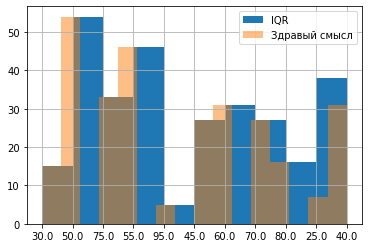

In [164]:
#Поскольку пропусков немного, оставим только те, где score>0
data=data.loc[data['score'].notnull()]
data[100:200]

# оценим наш входной параметр на количество встречающихся значений
data.score.hist()
plot_hist_se(data,'score',0,100)

#исправим тип данных ячейкам после чистки
for col in dict_types[list(dict_types.keys())[2]]:
    if col in data.columns:
        data[col] = data[col].apply(lambda x: float(x))
    
for col in dict_types[list(dict_types.keys())[1]]:
    if col in data.columns:
        data[col] = data[col].apply(lambda x: float(x))


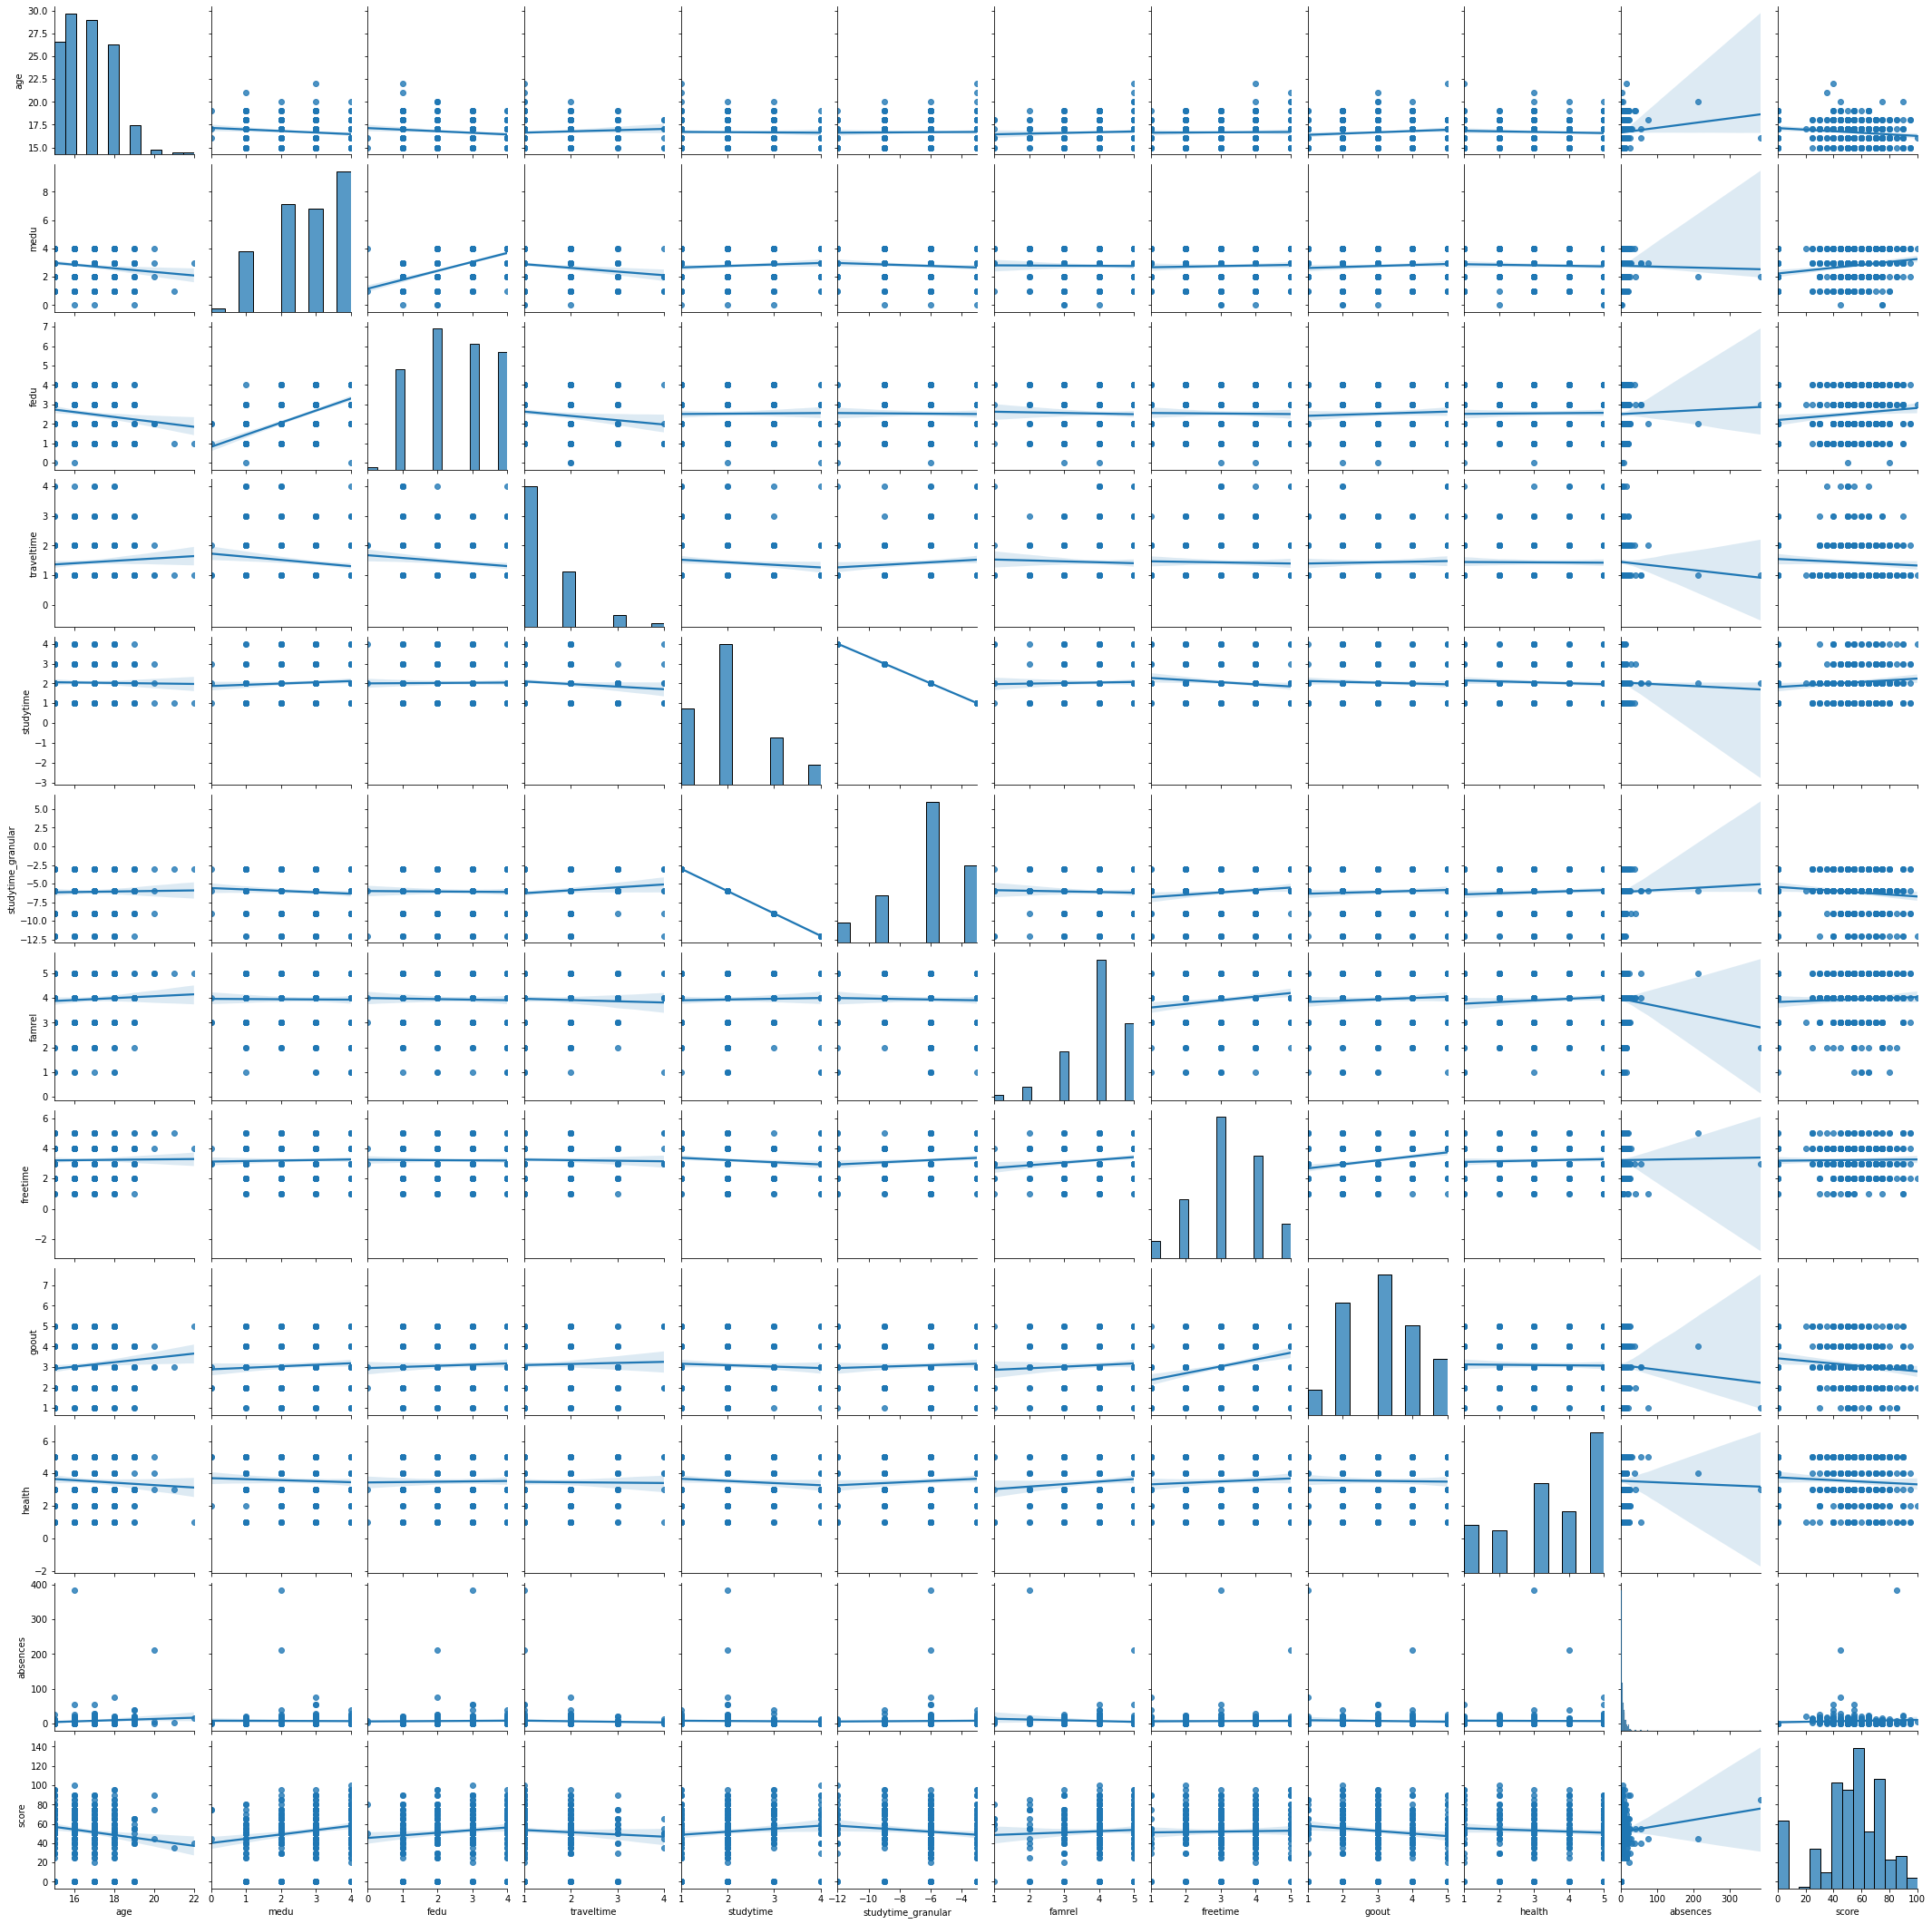

In [165]:
#проведем беглай корреляционный анализ
sns.pairplot(data, kind = 'reg')

In [166]:
display(clear_frame(data).corr())

,age,medu,fedu,traveltime,studytime,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.152625,-0.150359,0.104699,0.064465,-0.064465,0.033247,0.016705,0.105191,-0.049181,0.132736,-0.153518
medu,-0.152625,1.000000,0.636580,-0.123500,0.098234,-0.098234,0.072364,0.026660,0.072320,-0.048331,0.066439,0.213349
fedu,-0.150359,0.636580,1.000000,-0.075787,0.099739,-0.099739,0.001197,-0.031550,0.048724,0.002923,-0.023032,0.139615
traveltime,0.104699,-0.123500,-0.075787,1.000000,-0.137485,0.137485,-0.062575,-0.070042,-0.042190,-0.024299,-0.068964,-0.072792
studytime,0.064465,0.098234,0.099739,-0.137485,1.000000,-1.000000,0.080594,-0.095830,-0.053116,-0.041539,-0.079275,0.112830
studytime_granular,-0.064465,-0.098234,-0.099739,0.137485,-1.000000,1.000000,-0.080594,0.095830,0.053116,0.041539,0.079275,-0.112830
famrel,0.033247,0.072364,0.001197,-0.062575,0.080594,-0.080594,1.000000,0.106668,0.092562,0.032140,-0.023530,0.057692
freetime,0.016705,0.026660,-0.031550,-0.070042,-0.095830,0.095830,0.106668,1.000000,0.259038,0.060093,0.095524,0.000582
goout,0.105191,0.072320,0.048724,-0.042190,-0.053116,0.053116,0.092562,0.259038,1.000000,-0.018026,0.113048,-0.129685
health,-0.049181,-0.048331,0.002923,-0.024299,-0.041539,0.041539,0.032140,0.060093,-0.018026,1.000000,-0.013156,-0.070460


Заметна корреляция между studytime и studytime_granular. Количество пропусков одинаково, значения 4 позиционные. Можем отказаться от одного из них. Оставим только studytime.


In [167]:
#выкинем колонки с корреляцией
columnsForDrop=['studytime_granular']
for col in columnsForDrop:
    data.drop([col], inplace = True, axis = 1)  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  389 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


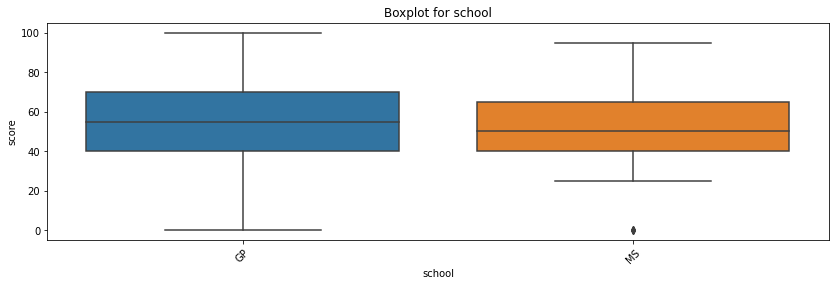

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     389 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


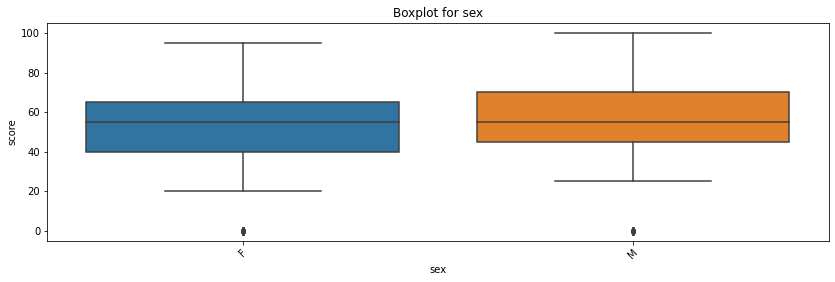

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     389 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].
Минимальное значение: 15.0
Максимальное значение: 22.0
8


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


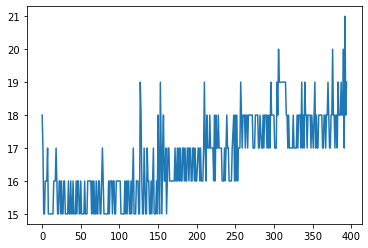

25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


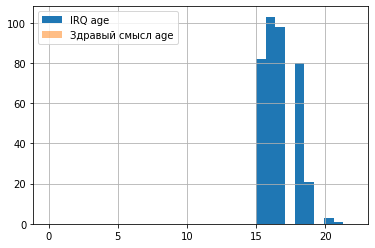

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


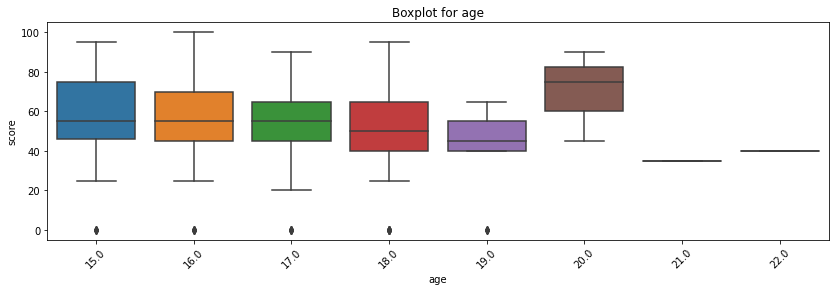

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  374 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


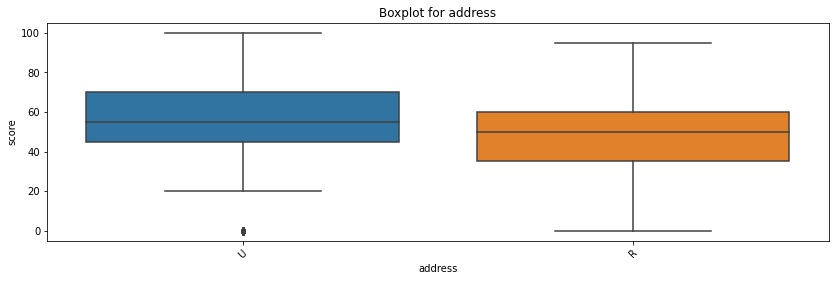

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  362 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


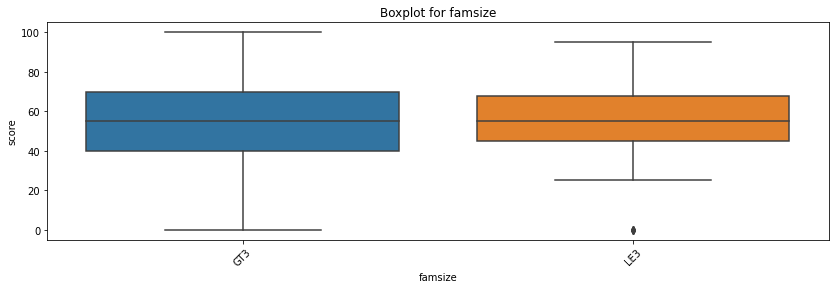

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  344 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


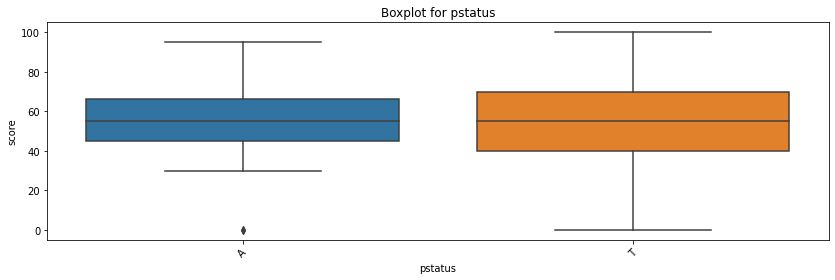

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    386 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Минимальное значение: 0.0
Максимальное значение: 4.0
5


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


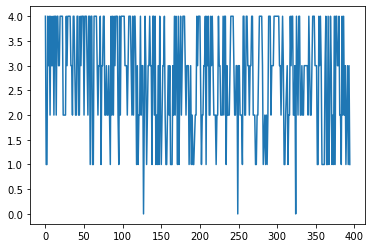

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


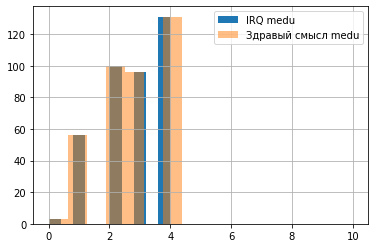

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


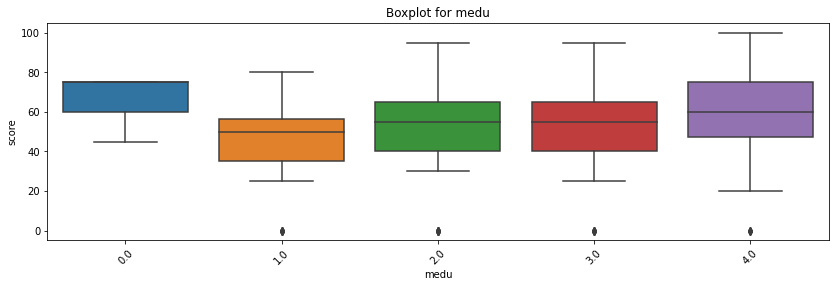

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    364 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].
Минимальное значение: 0.0
Максимальное значение: 4.0
5


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


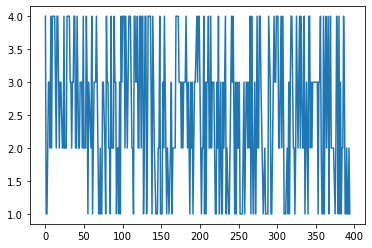

25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


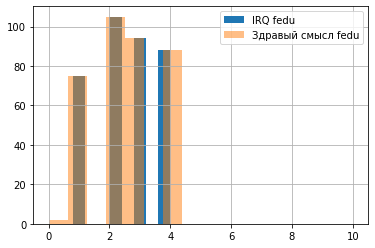

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


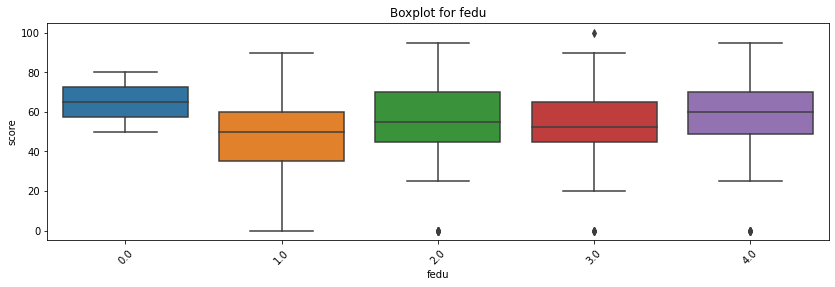

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    370 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


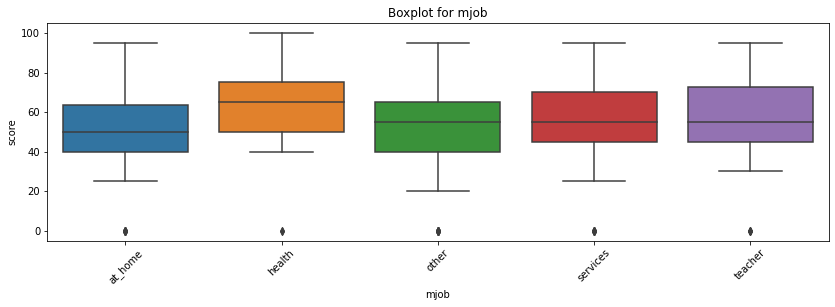

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    353 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


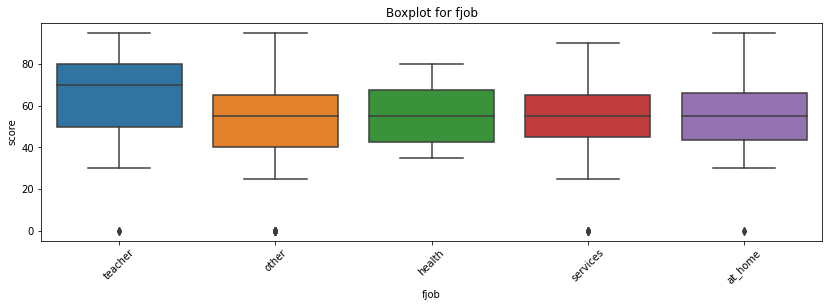

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  372 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


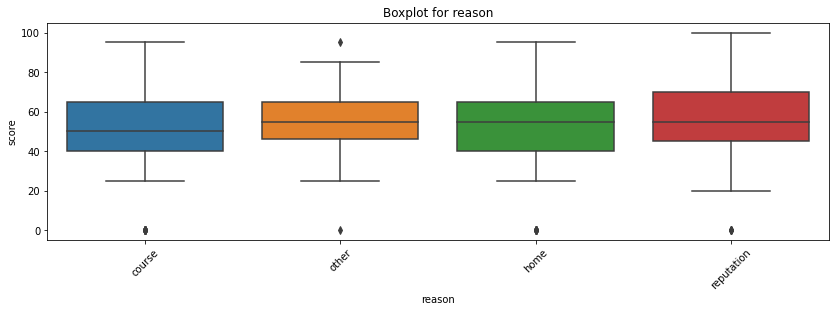

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  358 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


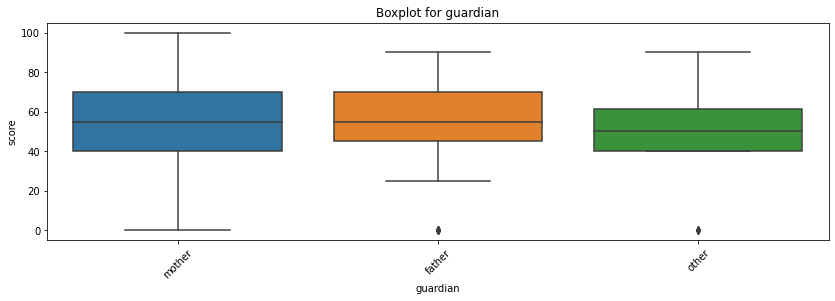

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  361 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Минимальное значение: 1.0
Максимальное значение: 4.0
4


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


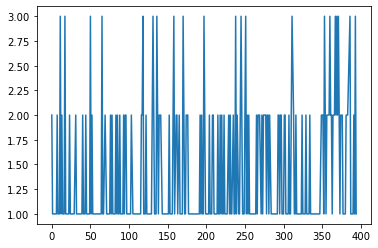

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


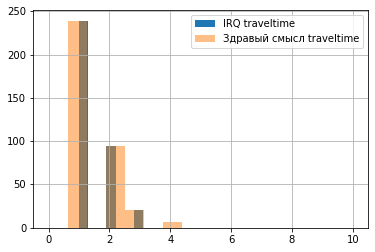

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


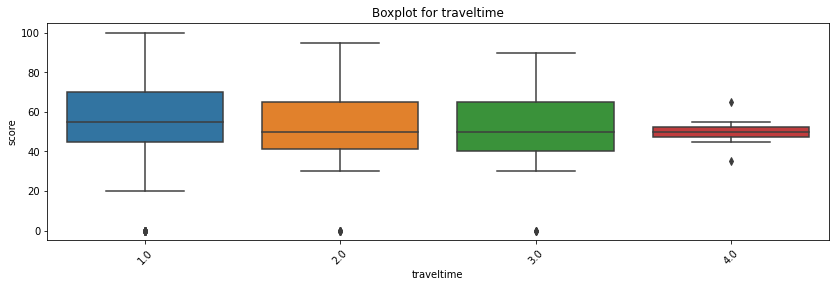

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  382 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Минимальное значение: 1.0
Максимальное значение: 4.0
4


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


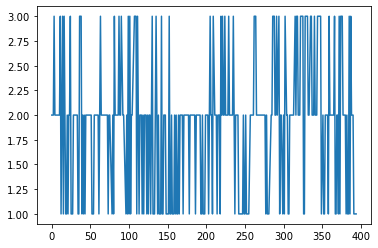

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


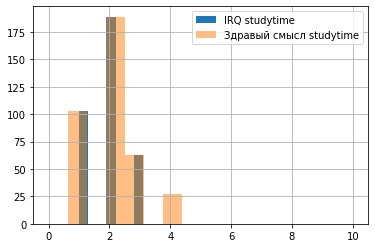

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


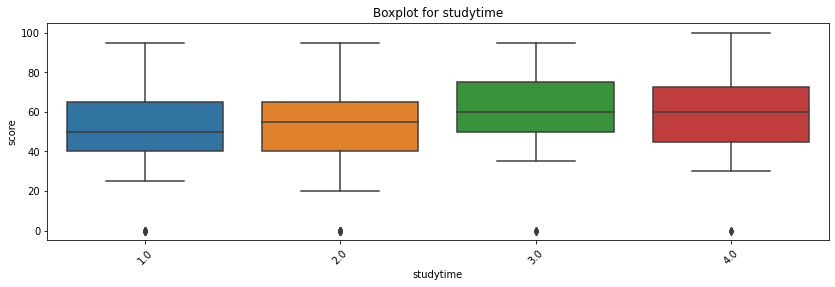

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  380 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


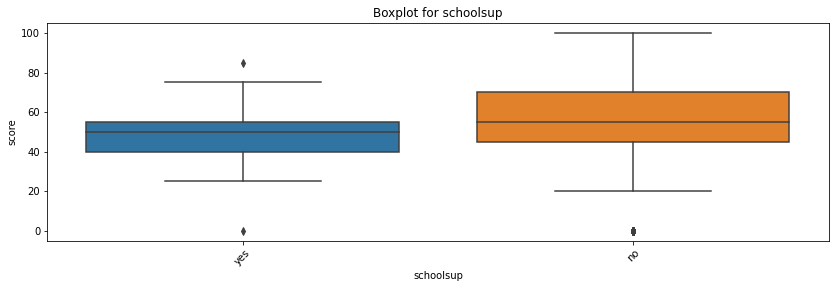

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  351 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


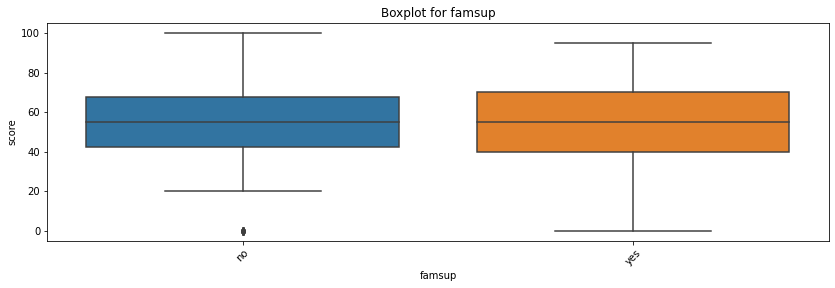

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    350 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


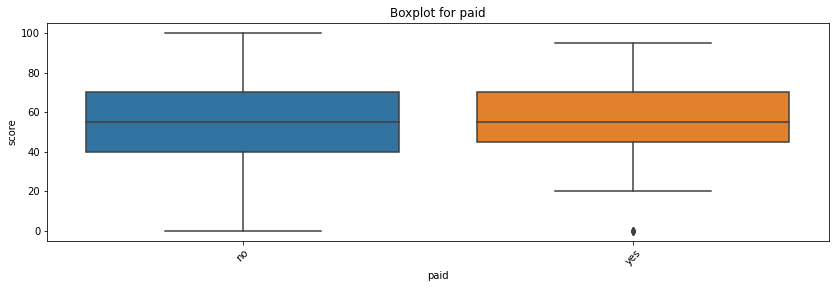

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  375 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


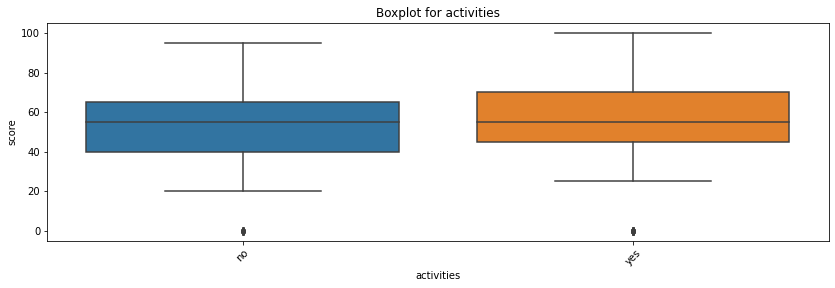

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  374 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


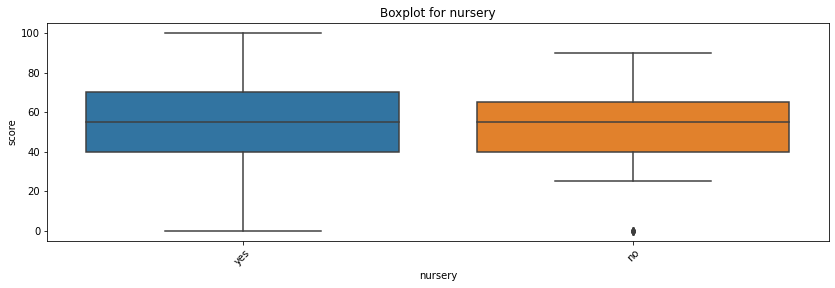

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  369 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


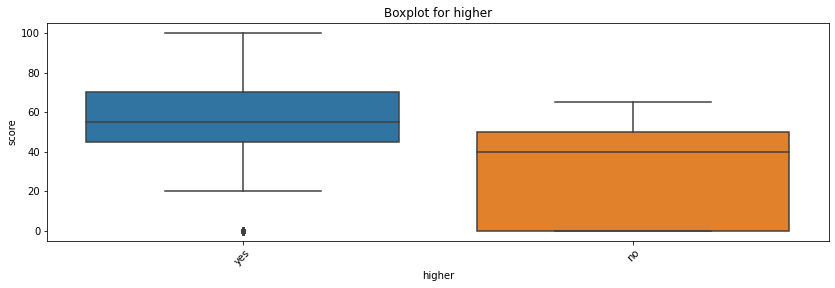

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  355 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


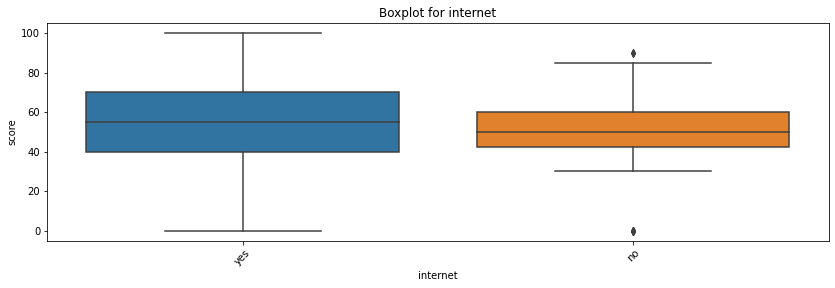

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  358 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


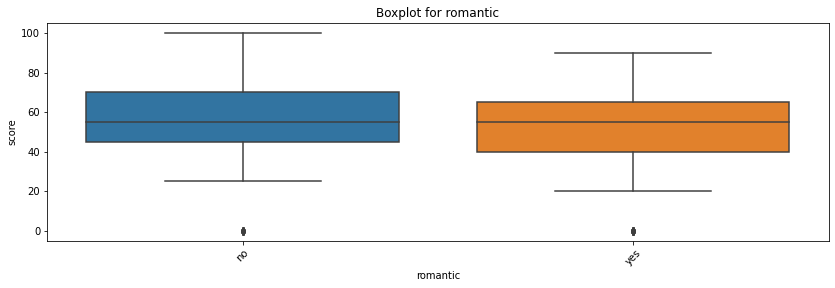

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  361 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


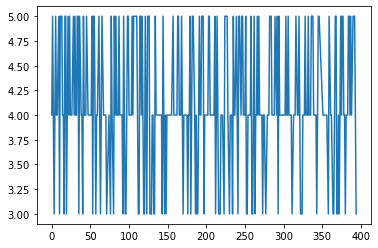

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


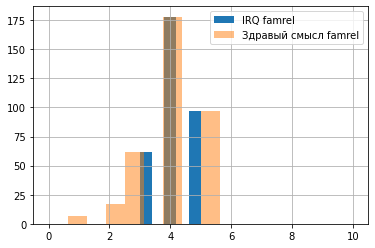

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


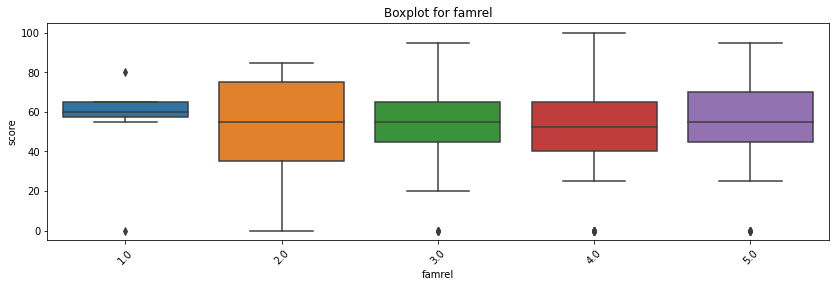

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  380 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


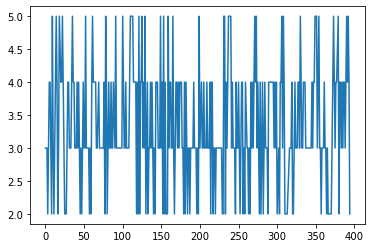

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


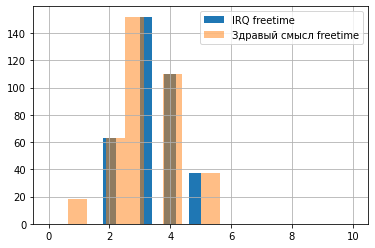

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


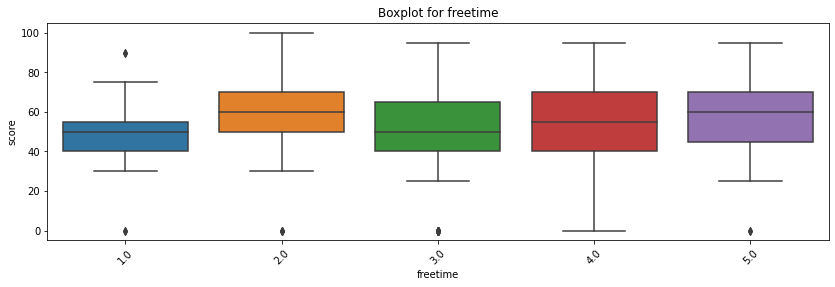

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   382 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


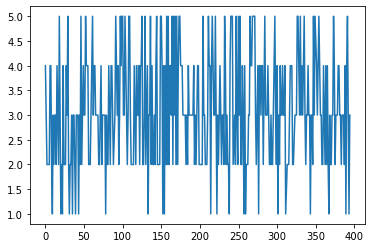

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


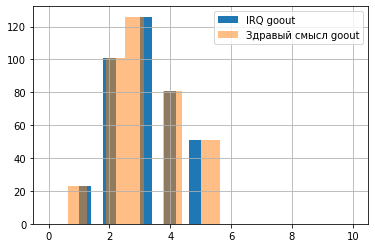

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


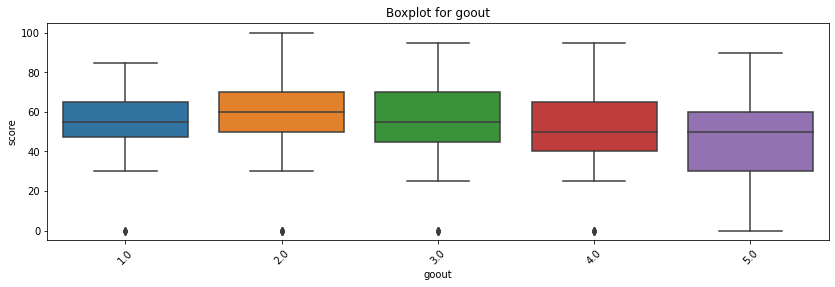

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  374 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].
Минимальное значение: 1.0
Максимальное значение: 5.0
5


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


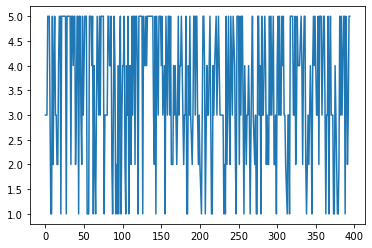

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


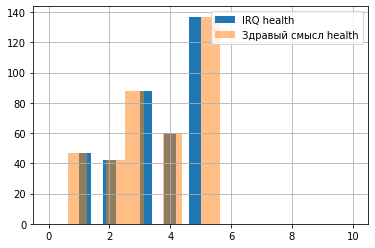

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


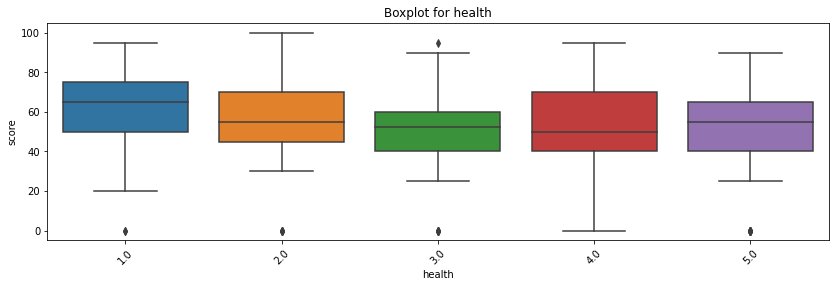

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  378 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].
Минимальное значение: 0.0
Максимальное значение: 385.0
36


<ipython-input-158-54446a691328>:80: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[field] == np.number):
<ipython-input-158-54446a691328>:24: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (frame.dtypes[fieldName] == np.number):


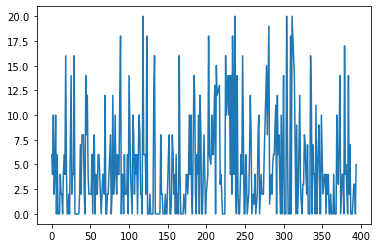

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


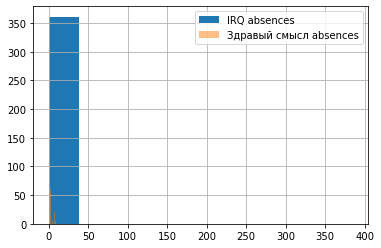

<ipython-input-158-54446a691328>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[axess]=frame[axess].apply(float)


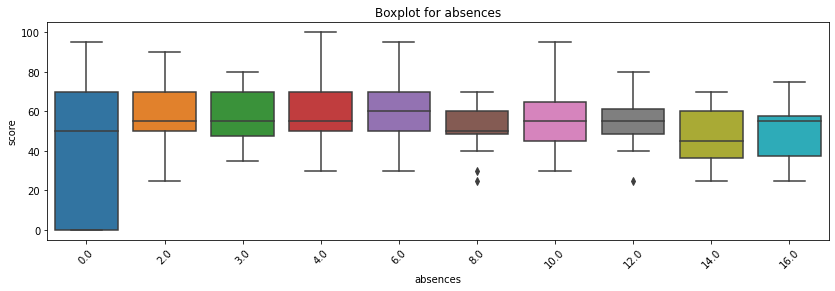

In [168]:
#проведем визуально-графический анализ
for col in data.columns[0:len(data.columns)-1]:
    get_info(data, col)

In [169]:
#Заметим что внутри ОДЗ есть выбросы в famrel, freetime,  studytime, traveltime, fedu
#Заметим что средний балвыше в школе GP
#Заметим что У мальчиков макимальная оценка лучше, чем у девочек, но в среднем успеваемость не зависит от пола
#По колонке возраст можно сделать вывод, что более активный возраст 15-16 лет для сдачи. Хороший показатель в 20-22 нельзя учитывать, так как в выборке их мало
# В среднем городские ребята учатся лучше
#В среднем от размера семьи оценка практически не зависит
#От статуса родителей средний бал не меняется, более широкие ворота могут быть связанны с взаимоотношениями внутри семьи
#Образование матери влияет на успеваемость
#Образование отца оказывает слабое влияние на успеваемость, но чем выше тем больше средний балл. Количество без образования мало для постановки выводов.
#Работа матери в области здравоохранения положительно влияет на успеваемость
#Работа отца учителем положительно влияет на успеваемость
#Причина выбора школы не влияет на успеваемость
#Если опекун один из родителей-это не влияет на успеваемость
#Время пути до школы оказывает влияние на успеваемость
#Время на подготовку вне школы оказывает влияние, но внутри каждой подкатегории есть выбросы в виде 0 балла. Думаю целесообразно повторить анализ исключив показатель 0
#Поддержка внутри школы оказывает негативное влияние, скорее всего потому что она оказывается нуждающимся и уже не успевающим 
#Поддержка семьи несильно влияет на результат
#Дополнительные платные занятия подтягивают минимальный бал вверх, но в среднем не влияют на оценку
#Дополнительная активность слабо влияет на результат, но более активные дети имеют лучше оценки
#Посещение детского сада слабо влияет на оценку по математике
#Среди учеников которые ставят перед собой цель поступить в ВУЗ оценка выше. 
#Дети у которых есть интернет имеют средний бал выше, но разброс так же увеличивается
#В среднем наличие романтических отношений негативно скахывается на оценке, хоть и незначительно
#Семейные отношения практически не влияют на результат
#Количество свободного времени оказывает слабое влияние, чем его больше тем результат может быть лучше
#Время препровождения с друзьями так же оказывает слабое влияние на результат. В данном случае умеренное значение дает лучший показатель
#Состояние здоровья оказывает влияние на результат- чем хуже здоровье тем хуже показатель
#Наличие прогулов и их количество не дает сделать однозначных выводов о результатах


In [170]:
#уточним методом Стъюдента оказывающие влияние колонки
for col in data.columns[0:len(data.columns)-1]:
    get_stat_dif(data, col, 'score')

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout
Найдены статистически значимые различия для колонки absences


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeW

In [171]:
#Посмотрим какие параметры влияют на прогулы
data=data.loc[data['absences'].notnull()]
for col in data.columns[0:len(data.columns)-2]:
    get_stat_dif(data, col, 'absences')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Найдены статистически значимые различия для колонки age
Найдены статистически значимые различия для колонки pstatus
Найдены статистически значимые различия для колонки guardian
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки famrel


In [172]:
data=data.loc[data['studytime'].notnull()]
for col in data.columns[0:len(data.columns)]:
    get_stat_dif(data, col, 'studytime')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeW

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки reason
Найдены статистически значимые различия для колонки traveltime
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки famsup
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
